 # Business Understanding

The goal of this project is to classify yoga poses into categories using deep learning. 
Specifically, we want to analyze images of people performing yoga poses (e.g., downdog, goddess pose) 
and predict the correct pose category using three deep learning architectures:
- Two architectures built from scratch
- One pre-trained architecture (e.g., MobileNetV2)

We will evaluate the performance of these models to identify the best approach.

# Data Requirements & Data Collection

In [1]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import plot_model

# ----------------------------
# Business Understanding
# ----------------------------
# The goal of this project is to develop a deep learning model capable of classifying yoga poses from images
# into predefined categories such as "downdog" and "goddess." The classification problem requires feature extraction
# from subtle differences between poses while accounting for challenges like low-quality images, illustrations, and text overlays.

# ----------------------------
# Data Requirements & Collection
# ----------------------------
data_dir_train = '../DATASET/TRAIN/'
data_dir_test = '../DATASET/TEST/'

# Confirm dataset structure
for folder in [data_dir_train, data_dir_test]:
    for class_name in os.listdir(folder):
        print(f"{class_name} contains {len(os.listdir(os.path.join(folder, class_name)))} images.")

downdog contains 223 images.
goddess contains 178 images.
downdog contains 97 images.
goddess contains 77 images.


# ----------------------------
# Data Understanding & Preparation
# ----------------------------

In [2]:

# Image data generators for preprocessing
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Split training data into training and validation subsets
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# Load data
train_generator = train_datagen.flow_from_directory(
    data_dir_train,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    data_dir_train,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    data_dir_test,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 322 images belonging to 2 classes.
Found 79 images belonging to 2 classes.
Found 174 images belonging to 2 classes.


# ----------------------------
# Data Modeling
# ----------------------------

In [7]:

# Model 1: LeNet-inspired CNN
def build_model_1():
    model = Sequential([
        Conv2D(32, (5, 5), activation='relu', input_shape=(150, 150, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (5, 5), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(120, activation='relu'),
        Dense(84, activation='relu'),
        Dense(train_generator.num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Model 2: DenseNet-inspired custom model
def build_model_2():
    input_shape = (150, 150, 3)
    inputs = tf.keras.Input(shape=input_shape)

    # First convolutional block
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    # Dense Block with concatenation
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    conv2 = Conv2D(32, (1, 1), activation='relu', padding='same')(x)
    x = tf.keras.layers.Concatenate()([conv1, conv2])

    # Continue with convolutional layers
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    # Flatten and fully connected layers
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(train_generator.num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Model 3: Pretrained EfficientNetB0
def build_model_3():
    base_model = tf.keras.applications.EfficientNetB0(
        weights='imagenet', include_top=False, input_shape=(150, 150, 3)
    )
    base_model.trainable = False  # Freeze base model layers

    model = Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(train_generator.num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model
    
# Create models
model_1 = build_model_1()
model_2 = build_model_2()
model_3 = build_model_3()

16705208/16705208 [==============================] - 7s 0us/step


# ----------------------------
# Model Training
# ----------------------------

In [8]:
def train_model(model, model_name):
    history = model.fit(
        train_generator,
        epochs=10,
        validation_data=validation_generator
    )
    model.save(f"{model_name}.h5")
    return history

history_1 = train_model(model_1, "model_1")
history_2 = train_model(model_2, "model_2")
history_3 = train_model(model_3, "model_3")

Epoch 1/10


c:\Users\aidou\anaconda3\envs\yoga-env\lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


11/11 [==============================] - 12s 1s/step - loss: 3.4945 - accuracy: 0.4907 - val_loss: 0.6950 - val_accuracy: 0.4051
Epoch 2/10
11/11 [==============================] - 8s 680ms/step - loss: 0.7093 - accuracy: 0.5497 - val_loss: 0.6876 - val_accuracy: 0.5570
Epoch 3/10
11/11 [==============================] - 7s 662ms/step - loss: 0.6872 - accuracy: 0.5590 - val_loss: 0.6668 - val_accuracy: 0.6329
Epoch 4/10
11/11 [==============================] - 8s 745ms/step - loss: 0.6785 - accuracy: 0.6429 - val_loss: 0.6643 - val_accuracy: 0.6709
Epoch 5/10
11/11 [==============================] - 8s 675ms/step - loss: 0.6547 - accuracy: 0.6304 - val_loss: 0.6333 - val_accuracy: 0.6709
Epoch 6/10
11/11 [==============================] - 8s 701ms/step - loss: 0.6316 - accuracy: 0.6646 - val_loss: 0.6484 - val_accuracy: 0.5570
Epoch 7/10
11/11 [==============================] - 8s 670ms/step - loss: 0.6385 - accuracy: 0.6180 - val_loss: 0.6271 - val_accuracy: 0.6709
Epoch 8/10
11/11 [=

c:\Users\aidou\anaconda3\envs\yoga-env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/10
11/11 [==============================] - 22s 2s/step - loss: 36.7930 - accuracy: 0.5155 - val_loss: 0.8254 - val_accuracy: 0.5316
Epoch 2/10
11/11 [==============================] - 18s 2s/step - loss: 25.7502 - accuracy: 0.6025 - val_loss: 1.7022 - val_accuracy: 0.5063
Epoch 3/10
11/11 [==============================] - 18s 2s/step - loss: 15.2741 - accuracy: 0.5901 - val_loss: 1.3019 - val_accuracy: 0.4810
Epoch 4/10
11/11 [==============================] - 20s 2s/step - loss: 6.7320 - accuracy: 0.5901 - val_loss: 2.2702 - val_accuracy: 0.6076
Epoch 5/10
11/11 [==============================] - 18s 2s/step - loss: 2.7359 - accuracy: 0.5528 - val_loss: 1.4891 - val_accuracy: 0.5316
Epoch 6/10
11/11 [==============================] - 19s 2s/step - loss: 1.0772 - accuracy: 0.5621 - val_loss: 2.1309 - val_accuracy: 0.5570
Epoch 7/10
11/11 [==============================] - 18s 2s/step - loss: 0.7493 - accuracy: 0.5714 - val_loss: 1.9365 - val_accuracy: 0.5570
Epoch 8/10
11/11 


# ----------------------------
# Model Evaluation
# ----------------------------

6/6 [==============================] - 4s 585ms/step - loss: 0.6869 - accuracy: 0.5575
Results: {'Model 1 (LeNet-inspired)': {'Loss': 0.5346781611442566, 'Accuracy': 0.7471264600753784}, 'Model 2 (DenseNet-inspired)': {'Loss': 3.9972057342529297, 'Accuracy': 0.568965494632721}, 'Model 3 (EfficientNetB0)': {'Loss': 0.6869182586669922, 'Accuracy': 0.5574712753295898}}


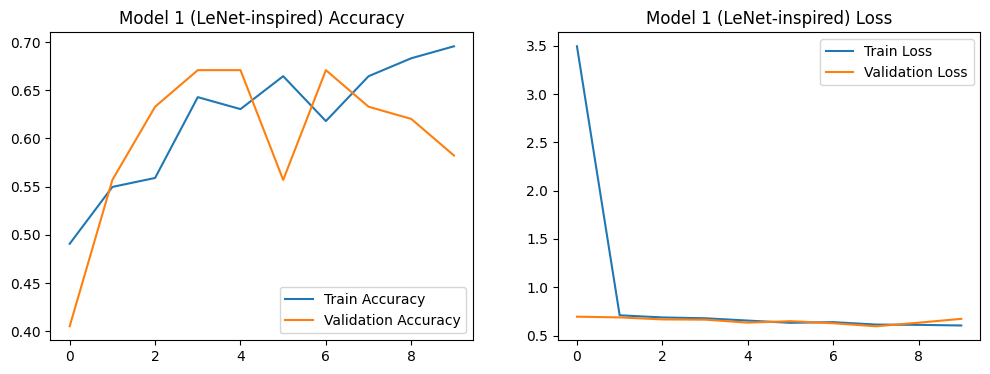

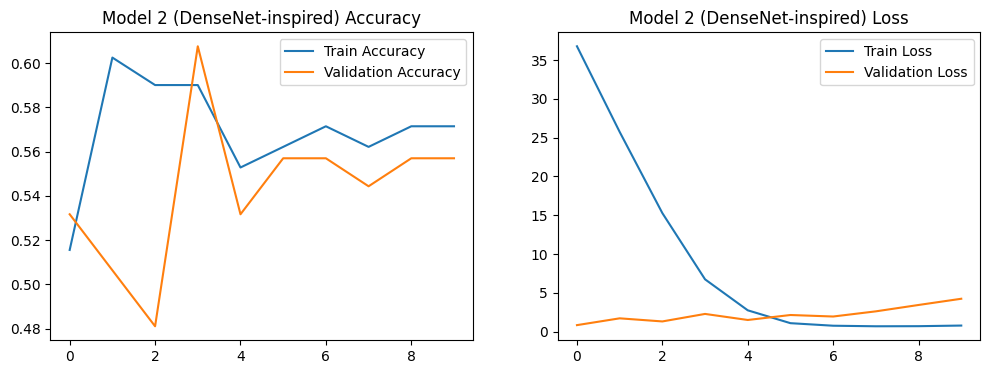

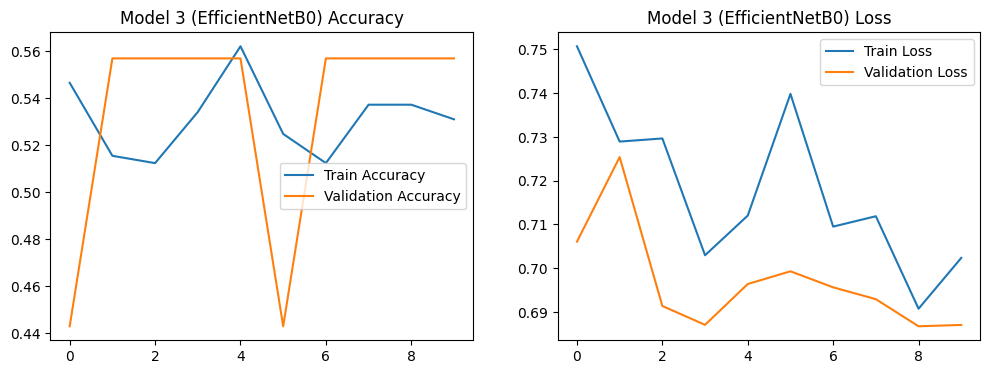

C:\Users\aidou\AppData\Local\Temp\ipykernel_17664\1371354600.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette="viridis")


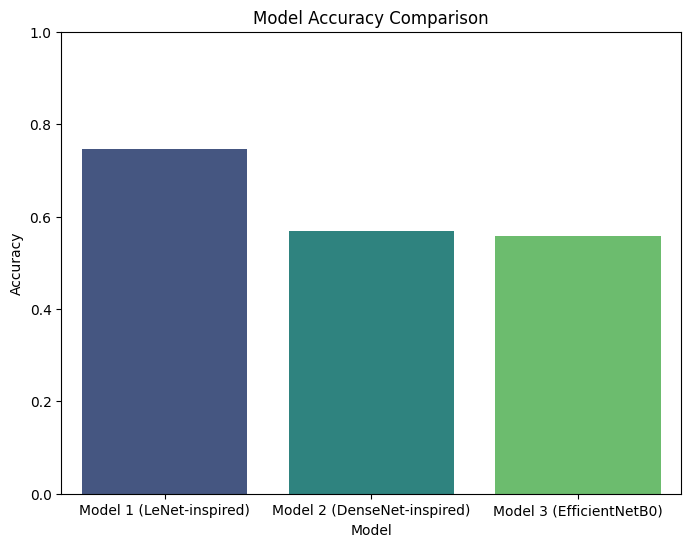

The best model is Model 1 (LeNet-inspired) with an accuracy of 0.75.
6/6 [==============================] - 3s 373ms/step


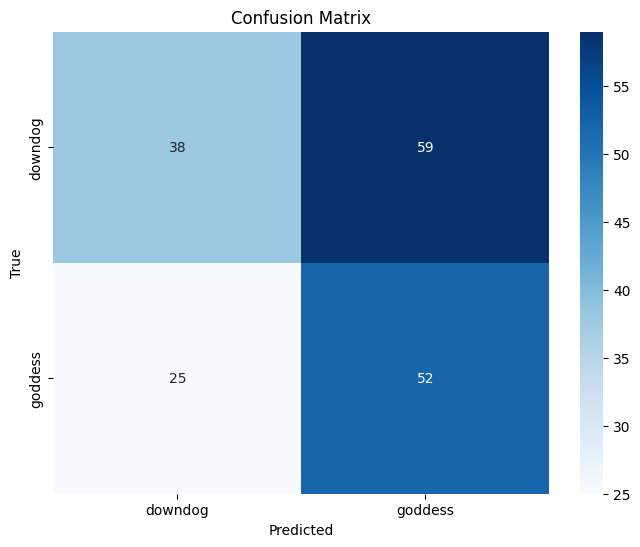

Classification Report:
              precision    recall  f1-score   support

     downdog       0.60      0.39      0.47        97
     goddess       0.47      0.68      0.55        77

    accuracy                           0.52       174
   macro avg       0.54      0.53      0.51       174
weighted avg       0.54      0.52      0.51       174



In [11]:
def evaluate_model(model, test_gen):
    loss, accuracy = model.evaluate(test_gen)
    return loss, accuracy

loss_1, acc_1 = evaluate_model(model_1, test_generator)
loss_2, acc_2 = evaluate_model(model_2, test_generator)
loss_3, acc_3 = evaluate_model(model_3, test_generator)
# Compare Results
results = {
    "Model 1 (LeNet-inspired)": {"Loss": loss_1, "Accuracy": acc_1},
    "Model 2 (DenseNet-inspired)": {"Loss": loss_2, "Accuracy": acc_2},
    "Model 3 (EfficientNetB0)": {"Loss": loss_3, "Accuracy": acc_3},
}

print("Results:", results)

# Visualize training process
def plot_history(history, model_name):
    plt.figure(figsize=(12, 4))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.legend()
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.legend()
    plt.show()

plot_history(history_1, "Model 1 (LeNet-inspired)")
plot_history(history_2, "Model 2 (DenseNet-inspired)")
plot_history(history_3, "Model 3 (EfficientNetB0)")
# Compare accuracy of models with a bar plot
import seaborn as sns
def plot_model_comparison(results):
    models = list(results.keys())
    accuracies = [results[model]["Accuracy"] for model in models]
    
    plt.figure(figsize=(8, 6))
    sns.barplot(x=models, y=accuracies, palette="viridis")
    plt.title("Model Accuracy Comparison")
    plt.ylabel("Accuracy")
    plt.xlabel("Model")
    plt.ylim(0, 1)
    plt.show()

plot_model_comparison(results)

# Choosing the best model
best_model_name = max(results, key=lambda x: results[x]['Accuracy'])
print(f"The best model is {best_model_name} with an accuracy of {results[best_model_name]['Accuracy']:.2f}.")

# Load the best model and make predictions
def predict_pose(model, test_gen):
    test_gen.reset()
    predictions = model.predict(test_gen)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_gen.classes
    class_labels = list(test_gen.class_indices.keys())

    # Plot confusion matrix
    from sklearn.metrics import confusion_matrix, classification_report
    cm = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    print("Classification Report:")
    print(classification_report(true_classes, predicted_classes, target_names=class_labels))

if best_model_name == "Model 1 (LeNet-inspired)":
    best_model = model_1
elif best_model_name == "Model 2 (DenseNet-inspired)":
    best_model = model_2
else:
    best_model = model_3

predict_pose(best_model, test_generator)


# ----------------------------
# Model Predictions
# ----------------------------

1/1 [==============================] - 0s 66ms/step


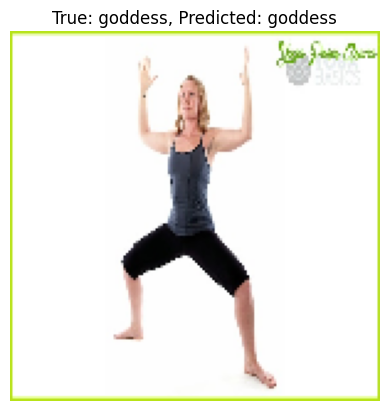

1/1 [==============================] - 0s 25ms/step


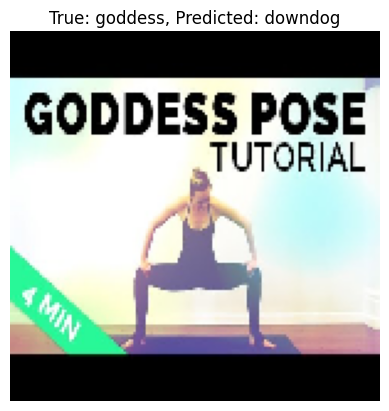

1/1 [==============================] - 0s 24ms/step


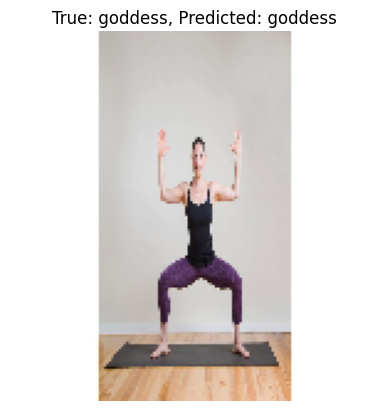

1/1 [==============================] - 0s 32ms/step


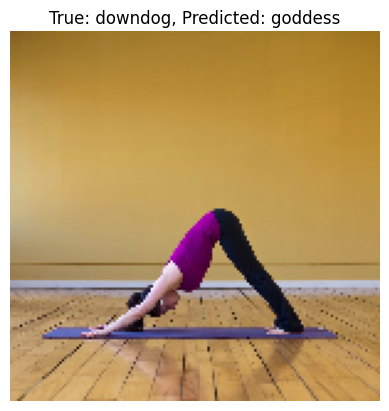

1/1 [==============================] - 0s 25ms/step


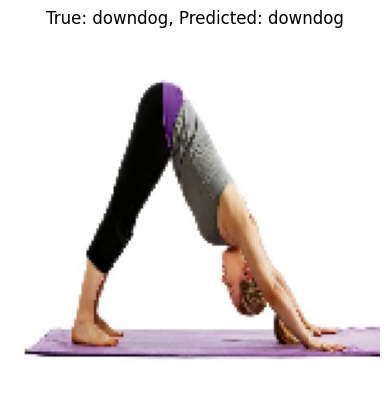

1/1 [==============================] - 0s 24ms/step


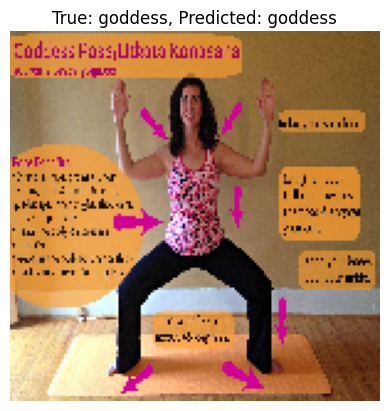

1/1 [==============================] - 0s 26ms/step


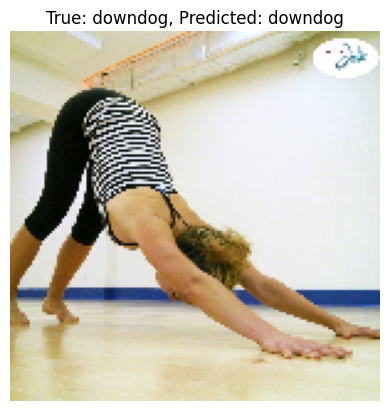

1/1 [==============================] - 0s 29ms/step


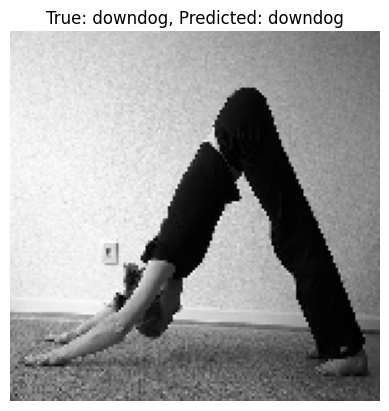

1/1 [==============================] - 0s 29ms/step


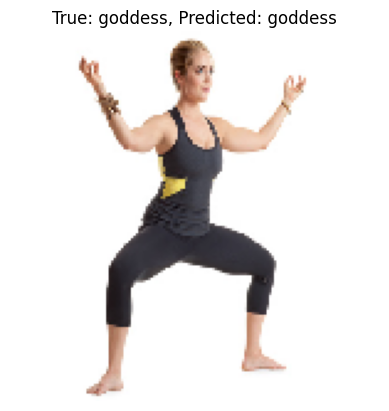

1/1 [==============================] - 0s 19ms/step


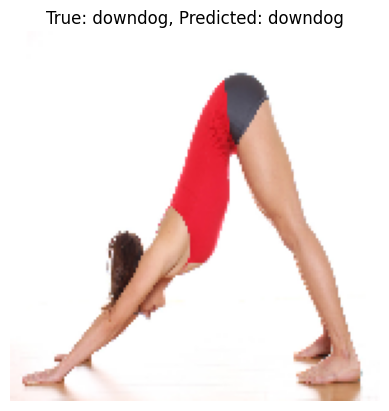

In [12]:
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def predict_random_images(model, test_dir, class_labels, num_images=10):
    """
    Predict yoga poses for a random selection of images from the test dataset.

    Parameters:
    - model: Trained model to use for prediction.
    - test_dir: Path to the test data directory.
    - class_labels: List of class labels.
    - num_images: Number of random images to predict.

    Returns:
    - None (displays predictions and images).
    """
    # Collect all images from the test directory
    all_images = []
    for class_name in os.listdir(test_dir):
        class_path = os.path.join(test_dir, class_name)
        all_images.extend([(os.path.join(class_path, img), class_name) for img in os.listdir(class_path)])
    
    # Randomly sample images
    selected_images = random.sample(all_images, num_images)

    # Predict and display results
    for img_path, true_label in selected_images:
        # Load and preprocess image
        img = load_img(img_path, target_size=(150, 150))
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        
        # Predict
        predictions = model.predict(img_array)
        predicted_class = class_labels[np.argmax(predictions)]

        # Display
        plt.imshow(img)
        plt.title(f"True: {true_label}, Predicted: {predicted_class}")
        plt.axis('off')
        plt.show()

# Extract class labels
class_labels = list(test_generator.class_indices.keys())

# Predict poses for 10 random images
predict_random_images(best_model, data_dir_test, class_labels, num_images=10)


In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import numpy as np
 
# Map class indices to class labels
class_labels = {v: k for k, v in test_data.class_indices.items()}
 
# Specify the image path under ../DATASET/
image_path = "../DATASET/goddessSquat_9542.jpg"  # Replace "test_image.jpg" with your image name
 
if not os.path.exists(image_path):
    raise FileNotFoundError(f"Image not found at path: {image_path}")
 
# Load and preprocess the image
img = tf.keras.utils.load_img(image_path, target_size=(150, 150))
img_array = tf.keras.utils.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)
 
# Predict the pose
prediction = best_model.predict(img_array)
predicted_class_index = np.argmax(prediction, axis=1)[0]
predicted_pose = class_labels[predicted_class_index]
 
# Display the image and prediction
plt.figure(figsize=(6, 6))
img_to_show = mpimg.imread(image_path)  # Read the original image for visualization
plt.imshow(img_to_show)
plt.title(f"Predicted Pose: {predicted_pose}", fontsize=14)
plt.axis('off')  # Hide axes for better visualization
plt.show()